In [ ]:
import pandas as pd
from sklearn.externals.joblib import dump,load
from sklearn.externals import joblib
import sklearn
from sklearn.metrics import mean_absolute_error
import os
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import sequence 
from keras.models import Sequential 
from keras.layers import Dense, Dropout,LSTM 
from numpy import array
from tensorflow import keras
from pandas import DataFrame
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from sklearn.metrics import f1_score
import pickle as pkl


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# convert series to supervised learning, taking the target values as features yt-1
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
train_values=pd.read_csv('/content/dengue_features_train.csv')
train_values.shape

(1456, 24)

In [ ]:
train_labels=pd.read_csv('/content/dengue_labels_train.csv')
train_labels.shape

(1456, 4)

In [ ]:
train_values

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


In [ ]:
train_values.shape

(1456, 24)

In [ ]:
train_labels.drop(columns=['year','weekofyear'], axis=1, inplace=True)

In [ ]:
test_values=pd.read_csv('/content/dengue_features_test.csv')
test_values.shape

(416, 24)

In [ ]:
san_juan=train_values[(train_values['city']=='sj')]
san_juan=san_juan[['week_start_date']]


In [ ]:
san_juan_cases_for_week=pd.concat([san_juan,train_labels],axis=1)
san_juan_cases_for_week.dropna(inplace=True)

In [ ]:
san_juan_cases_for_week

,week_start_date,city,total_cases
0,1990-04-30,sj,4
1,1990-05-07,sj,5
2,1990-05-14,sj,4
3,1990-05-21,sj,3
4,1990-05-28,sj,6
...,...,...,...
931,2008-03-25,sj,4
932,2008-04-01,sj,3
933,2008-04-08,sj,1
934,2008-04-15,sj,3


Text(0, 0.5, 'total_cases')

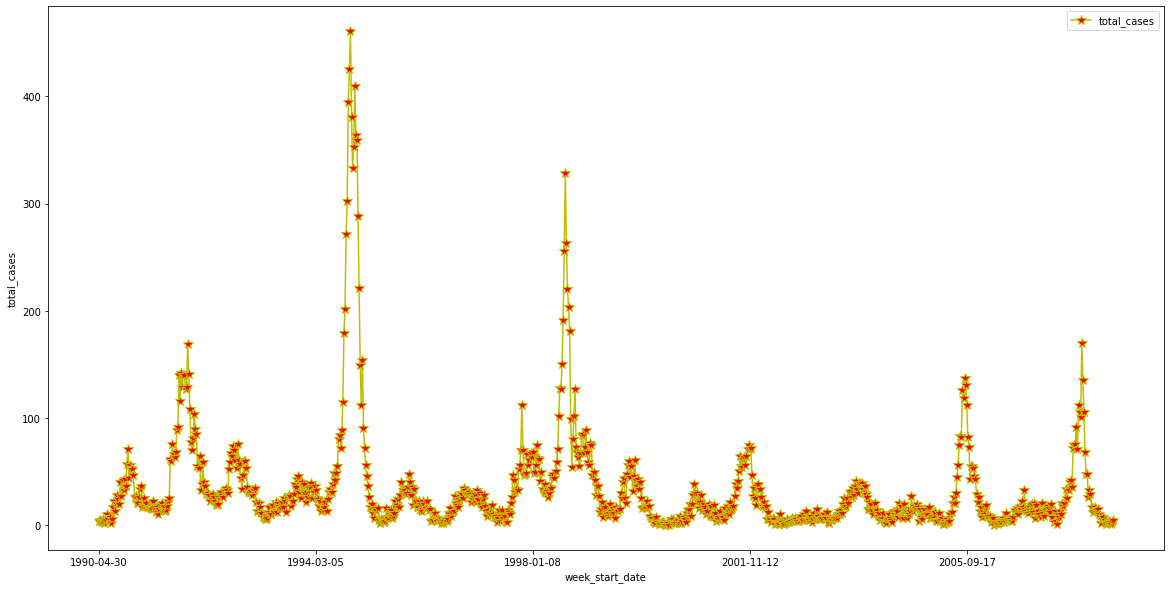

In [ ]:
san_juan_cases_for_week.plot(x='week_start_date',y='total_cases',figsize=(20,10),linestyle='-', marker='*', markerfacecolor='r',color='y',markersize=10)

plt.xlabel('week_start_date')
plt.ylabel('total_cases')

In [ ]:
train_values.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,303.427109,295.719156,40.151819,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,3.234601,2.565364,43.434399,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,301.000000,293.900000,13.055000,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,302.400000,296.200000,27.245000,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,305.500000,297.900000,52.200000,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


In [ ]:
train_labels.describe()

,total_cases
count,1456.000000
mean,24.675137
std,43.596000
min,0.000000
25%,5.000000
50%,12.000000
75%,28.000000
max,461.000000


In [ ]:
City_hotencode = pd.get_dummies(train_values['city']) #I will trasform the categorical variable into a one hot econde feature

In [ ]:
City_hotencode.head()

,iq,sj
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [ ]:
X=train_values.iloc[:,4:]
X=pd.concat([City_hotencode,X],axis=1)

In [ ]:
X.head()

,iq,sj,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,0,1,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,0,1,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,0,1,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,0,1,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,0,1,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [ ]:
from sklearn.impute import KNNImputer

columns=X.columns
#I noticed the are NaN values, let's replace using the KNN imputer 
imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
X=imputer.fit_transform(X)
X=pd.DataFrame(data=X, columns=columns)
X.head()

,iq,sj,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,0.0,1.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,0.0,1.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,0.0,1.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,0.0,1.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,0.0,1.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [ ]:
X.shape
y=train_labels.iloc[:,1:]
dataset=pd.concat([y,X],axis=1)
dataset

,total_cases,iq,sj,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,4,0.0,1.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,5,0.0,1.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,4,0.0,1.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,3,0.0,1.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,6,0.0,1.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,5,1.0,0.0,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,8,1.0,0.0,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,1,1.0,0.0,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,1,1.0,0.0,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))

#
values=dataset.values

scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1,)
with open("scaler.pkl", "wb") as outfile:
  pkl.dump(scaler, outfile) #save scaler


In [ ]:
y

,total_cases
0,4
1,5
2,4
3,3
4,6
...,...
1451,5
1452,8
1453,1
1454,1


In [ ]:

reframed.drop(reframed.columns[24:], axis=1, inplace=True)
#reframed['var1(t-1)']=y.astype('float32')
#reframed['var1(t)']=reframed['var1(t-1)'].shift(-1).astype('float32')
#reframed.dropna(axis=0,inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var1(t)
1,-0.982646,-1.0,1.0,0.156453,0.229670,-0.227164,-0.208912,-0.936406,-0.223418,-0.290667,-0.370641,-0.753086,0.384615,-0.887818,-0.236772,-0.936406,-0.474681,-0.826680,-0.139818,-0.579214,-0.651613,-0.027523,-0.941101,-0.978308
2,-0.978308,-1.0,1.0,0.259885,0.314127,-0.357620,-0.281535,-0.883154,-0.054580,-0.116444,-0.021573,-0.617284,0.461538,-0.937108,-0.040663,-0.883154,-0.163672,-0.861733,0.130699,-0.673004,-0.354839,0.376147,-0.968342,-0.982646
3,-0.982646,-1.0,1.0,-0.041118,0.381762,-0.376242,-0.231140,-0.823144,0.096128,-0.008000,0.315166,-0.666667,0.600000,-0.908501,0.188830,-0.823144,0.173799,-0.871470,0.130699,-0.652725,-0.290323,0.486239,-0.847598,-0.986985
4,-0.986985,-1.0,1.0,0.169646,0.540131,-0.122176,-0.017701,-0.921352,0.150519,0.079111,0.286942,-0.555556,0.553846,-0.951271,0.104773,-0.921352,0.133616,-0.853944,0.291793,-0.602028,-0.148387,0.577982,-0.985275,-0.973970
5,-0.973970,-1.0,1.0,0.317396,0.577765,-0.036799,0.019887,-0.961495,0.291029,0.187556,0.403082,-0.493827,0.630769,-0.957230,0.110792,-0.961495,0.256452,-0.774099,0.604863,-0.140684,0.070968,0.688073,-0.978649,-0.991323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,-0.973970,1.0,-1.0,0.463626,0.600389,-0.011263,0.010567,-0.994112,-0.203399,-0.050667,-0.186050,0.345679,-0.507692,-0.969150,0.039194,-0.994112,-0.269846,0.347614,-0.099291,-0.171103,-0.058065,-0.027523,-0.990797,-0.978308
1452,-0.978308,1.0,-1.0,0.637862,0.702308,-0.018227,0.168127,-0.716846,0.242304,0.463111,0.631144,0.469136,0.169231,-0.842244,0.517707,-0.716846,0.548187,0.150925,0.539007,0.313899,0.122581,0.412844,-0.900607,-0.965293
1453,-0.965293,1.0,-1.0,0.238580,0.354096,-0.452643,-0.051266,-0.557245,-0.023229,0.120000,0.546472,0.320988,-0.230769,-0.273970,0.656565,-0.557245,0.453120,-0.166504,0.283688,0.059569,0.032258,0.284404,-0.865268,-0.995662
1454,-0.995662,1.0,-1.0,0.428607,0.322654,-0.039843,-0.024826,-0.698208,-0.481020,-0.328000,0.330414,-0.049383,-0.153846,-0.822612,0.787864,-0.698208,0.210389,-0.162610,-0.361702,-0.579214,-0.290323,-0.174312,-0.972759,-0.995662


In [ ]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var1(t)
1,-0.982646,-1.0,1.0,0.156453,0.229670,-0.227164,-0.208912,-0.936406,-0.223418,-0.290667,-0.370641,-0.753086,0.384615,-0.887818,-0.236772,-0.936406,-0.474681,-0.826680,-0.139818,-0.579214,-0.651613,-0.027523,-0.941101,-0.978308
2,-0.978308,-1.0,1.0,0.259885,0.314127,-0.357620,-0.281535,-0.883154,-0.054580,-0.116444,-0.021573,-0.617284,0.461538,-0.937108,-0.040663,-0.883154,-0.163672,-0.861733,0.130699,-0.673004,-0.354839,0.376147,-0.968342,-0.982646
3,-0.982646,-1.0,1.0,-0.041118,0.381762,-0.376242,-0.231140,-0.823144,0.096128,-0.008000,0.315166,-0.666667,0.600000,-0.908501,0.188830,-0.823144,0.173799,-0.871470,0.130699,-0.652725,-0.290323,0.486239,-0.847598,-0.986985
4,-0.986985,-1.0,1.0,0.169646,0.540131,-0.122176,-0.017701,-0.921352,0.150519,0.079111,0.286942,-0.555556,0.553846,-0.951271,0.104773,-0.921352,0.133616,-0.853944,0.291793,-0.602028,-0.148387,0.577982,-0.985275,-0.973970
5,-0.973970,-1.0,1.0,0.317396,0.577765,-0.036799,0.019887,-0.961495,0.291029,0.187556,0.403082,-0.493827,0.630769,-0.957230,0.110792,-0.961495,0.256452,-0.774099,0.604863,-0.140684,0.070968,0.688073,-0.978649,-0.991323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,-0.973970,1.0,-1.0,0.463626,0.600389,-0.011263,0.010567,-0.994112,-0.203399,-0.050667,-0.186050,0.345679,-0.507692,-0.969150,0.039194,-0.994112,-0.269846,0.347614,-0.099291,-0.171103,-0.058065,-0.027523,-0.990797,-0.978308
1452,-0.978308,1.0,-1.0,0.637862,0.702308,-0.018227,0.168127,-0.716846,0.242304,0.463111,0.631144,0.469136,0.169231,-0.842244,0.517707,-0.716846,0.548187,0.150925,0.539007,0.313899,0.122581,0.412844,-0.900607,-0.965293
1453,-0.965293,1.0,-1.0,0.238580,0.354096,-0.452643,-0.051266,-0.557245,-0.023229,0.120000,0.546472,0.320988,-0.230769,-0.273970,0.656565,-0.557245,0.453120,-0.166504,0.283688,0.059569,0.032258,0.284404,-0.865268,-0.995662
1454,-0.995662,1.0,-1.0,0.428607,0.322654,-0.039843,-0.024826,-0.698208,-0.481020,-0.328000,0.330414,-0.049383,-0.153846,-0.822612,0.787864,-0.698208,0.210389,-0.162610,-0.361702,-0.579214,-0.290323,-0.174312,-0.972759,-0.995662


In [ ]:
# split into train and test sets
values = reframed.values

#let's use 85% of weeks for training 
train_weeks=round(0.7*len(reframed))
train = values[:train_weeks, :]
test = values[train_weeks:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input  define model

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1018, 1, 23) (1018,) (437, 1, 23) (437,)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
model2=Sequential()
model2.add(LSTM(21, return_sequences=True, input_shape=(None,train_X.shape[2])))
model2.add(LSTM(64, return_sequences=True))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(21, return_sequences=True)) 
model2.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.000001)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer=keras.optimizers.SGD(learning_rate=lr_schedule)
#model.compile(loss='mse', optimizer=optimizer, metrics='accuracy')
model2.compile(loss='mse', optimizer=opt, metrics='accuracy')

In [ ]:
model2=model2.save('/content/saved_model2')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/saved_model2/assets


In [ ]:
model2=keras.models.load_model('/content/saved_model2/')
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.000001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer=keras.optimizers.SGD(learning_rate=lr_schedule)
opt = keras.optimizers.Adam(learning_rate=0.00000001)
model2.compile(loss='mse', optimizer=optimizer, metrics='accuracy')
model2.fit(train_X, train_y, epochs=5000, batch_size=1)  
model2=model2.save('/content/saved_model2')


Epoch 1/5000
1018/1018 [==============================] - 4s 4ms/step - loss: 1.8601e-05 - accuracy: 9.8232e-04
Epoch 2/5000
1018/1018 [==============================] - 3s 3ms/step - loss: 1.8814e-05 - accuracy: 9.8232e-04
Epoch 3/5000
1018/1018 [==============================] - 3s 3ms/step - loss: 1.9258e-05 - accuracy: 9.8232e-04
Epoch 4/5000
1018/1018 [==============================] - 3s 3ms/step - loss: 1.5667e-05 - accuracy: 9.8232e-04
Epoch 5/5000
1018/1018 [==============================] - 3s 3ms/step - loss: 3.1437e-05 - accuracy: 9.8232e-04
Epoch 6/5000
1018/1018 [==============================] - 3s 3ms/step - loss: 1.7329e-05 - accuracy: 9.8232e-04
Epoch 7/5000
1018/1018 [==============================] - 3s 3ms/step - loss: 1.5465e-05 - accuracy: 9.8232e-04
Epoch 8/5000
1018/1018 [==============================] - 3s 3ms/step - loss: 1.7091e-05 - accuracy: 9.8232e-04
Epoch 9/5000
1018/1018 [==============================] - 3s 3ms/step - loss: 1.7725e-05 - accuracy: 9.8

In [ ]:
model2=model2.save('/content/saved_model2')

INFO:tensorflow:Assets written to: /content/saved_model2/assets


In [ ]:
model2=keras.models.load_model('/content/saved_model2/')
yhat=model2.predict(test_X)
y_pred=yhat.reshape(yhat.shape[0],yhat.shape[1])
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2])) # we set as initial shape
y_pred=concatenate((y_pred, test_X[:,1:]), axis=1)# concatenate as first column label and the rest
y_pred=scaler.inverse_transform(y_pred)#let's invert normalization
y_pred=y_pred[:,0]
#we make same for actual values
test_y = test_y.reshape((len(test_y), 1))
y_test=concatenate((test_y, test_X[:,1:]), axis=1)# concatenate as first column label and the rest
y_test=scaler.inverse_transform(y_test)#let's invert normalization
y_test=y_test[:,0]

yt_test=y_test.astype('int64')
yp_test=y_pred.astype('int64')
after_train = f1_score(yt_test,yp_test,average='weighted')
mae_score=mean_absolute_error(yt_test,yp_test)
print('Test loss after Training' , after_train.item())

Test loss after Training 0.3823301318748381


In [ ]:
mae_score=mean_absolute_error(yt_test,yp_test)
print(f'mae:', {mae_score})

mae: {3.272311212814645}


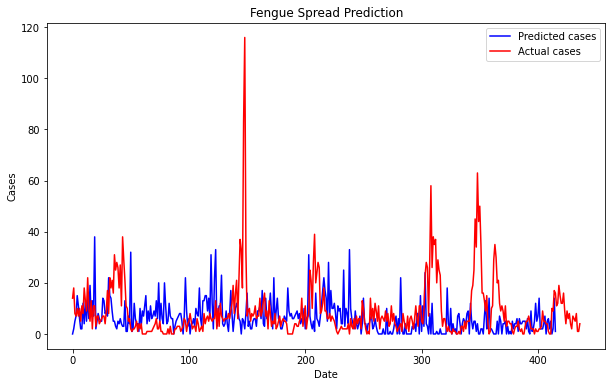

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(yp_test, color='blue', label='Predicted cases')
plt.plot(y_test, color='red', label='Actual cases')
plt.title('Fengue Spread Prediction')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.show()

In [ ]:
test_values=pd.read_csv('/content/dengue_features_test.csv')

X=test_values.drop(columns=['year','weekofyear','week_start_date'], axis=1)
City_hotencode = pd.get_dummies(test_values['city']) 
X=pd.concat([City_hotencode,X],axis=1)
X=X.drop(['city'],axis=1)
columns=X.columns
#I noticed the are NaN values, let's replace using the KNN imputer 
imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
X=imputer.fit_transform(X)
X=pd.DataFrame(data=X, columns=columns)
X.insert(0,'Cases t-1',0)#we add the yt-1 feature
X=X.dropna(axis=0)
sj_index=X[(X['sj'])==1].last_valid_index() #we store the index value for sj cases 
with open("scaler.pkl", "rb") as infile:
    scaler = pkl.load(infile)
    X=scaler.transform(X)
#X=scaler.transform(X)
X[0,0]=-1 #we set y-t1 for san juan as our last value in the training dataset
X_sj=X[:sj_index+1,:] # we split the batch for sj and iq
X_iq=X[sj_index+1:,:]
X_iq[0,0]=-0.982646 # we set yt-1 for puerto rico as our last value in the training dataset


In [ ]:
#let's predict for puert rico
y_t1_iq=[] #store the variable predicted at t-1
e=0 

X_iq=X_iq.reshape(X_iq.shape[0],1,X_iq.shape[1])
X_iq_a=np.empty(shape=(1,23)) #we store a new array for puerto rico
for i in X_iq:
  for x_batch in i:
    x_batch=x_batch.reshape(1,1,x_batch.shape[0])
    yhat=model2.predict(x_batch)
    x_batch=x_batch.reshape(x_batch.shape[-1])
    y_t1_iq.append(yhat)
    if e > 0:
      x_batch[0]=y_t1_iq[(e-1)]
    e = e+1
  X_iq_a=np.append(X_iq_a,i,axis=0)

X_iq_a=X_iq_a[1:,:] #we exclude the first initialized row
y_t1_iq=np.array(y_t1_iq)
y_t1_iq=y_t1_iq.reshape(y_t1_iq.shape[0],1)

In [ ]:
#let's predict for san juan
y_t1_sj=[] #store the variable predicted at t-1
e=0 

X_sj=X_sj.reshape(X_sj.shape[0],1,X_sj.shape[1])
X_iq_s=np.empty(shape=(1,23)) #we store a new array for puerto rico
for i in X_sj:
  for x_batch in i:
    x_batch=x_batch.reshape(1,1,x_batch.shape[0])
    yhat=model2.predict(x_batch)
    x_batch=x_batch.reshape(x_batch.shape[-1])
    y_t1_sj.append(yhat)
    if e > 0:
      x_batch[0]=y_t1_sj[(e-1)]
    e = e+1
  X_iq_s=np.append(X_iq_s,i,axis=0)

X_iq_s=X_iq_s[1:,:] #we exclude the first initialized row
y_t1_sj=np.array(y_t1_sj)
y_t1_sj=y_t1_sj.reshape(y_t1_sj.shape[0],1)

In [ ]:
#now we need to apply the inverse transformation
y_t1=np.concatenate([y_t1_sj,y_t1_iq],axis=0) #we transform concatenate y_t1 in unique array
y_pred=concatenate((y_t1,X[:,1:]), axis=1)# concatenate as first column label and the rest
y_pred=scaler.inverse_transform(y_pred)#let's invert normalization
y_pred=y_pred[:,0]
yp_test=y_pred.astype('int64')
yp_test



array([ 0,  2,  5,  7, 15, 11,  6,  2,  2, 12,  4, 13,  5, 15,  6, 19,  7,
       13,  7, 38,  2,  5,  8,  6,  5,  5, 14, 13,  8,  9,  7, 22, 15, 14,
        9,  5,  5,  3,  2,  5,  4,  6,  4,  3,  3, 13,  1,  1,  7,  4, 32,
        1,  2, 12,  6,  4,  4,  1, 10,  3,  9,  7, 11, 15,  4,  9,  5, 11,
        6,  7,  9,  7, 13,  6, 20,  5, 12,  6,  4, 20, 11,  4,  5, 12,  7,
        6,  6,  0,  3,  5,  6,  7,  8,  8,  5,  0,  7, 22,  9,  3,  6,  0,
        4,  4,  6,  3, 10,  8,  7, 18,  6,  3, 13, 13, 15, 15,  9, 14,  6,
       31, 12,  2, 22, 33,  3,  8, 11, 11, 23,  4,  3,  4,  9,  4,  1,  8,
       17,  8,  1,  6, 10, 12, 10,  6,  5,  0,  6,  5,  2,  8, 16,  3,  5,
        2,  2,  5,  6,  6,  3,  9,  9, 11,  6, 17,  4,  3, 14,  6,  6, 10,
       16,  8,  2, 22,  4,  9, 14,  6,  5,  2,  2,  4,  7,  6,  5, 18,  9,
        7,  8,  6,  6,  7,  8,  9,  6,  8,  4,  6,  4, 10,  2,  6,  7, 31,
        7,  4,  2,  5,  1, 16,  6,  5,  3,  7, 12, 17, 22, 17, 14,  5, 28,
        7, 17, 10, 10, 12

In [ ]:
test_values=test_values.iloc[:,:3]
test_values['total_cases']=yp_test


In [ ]:
test_values=test_values.to_csv('/content/cases_predicted.csv',index=False)